In [1]:
import os
import keras
import io
import csv

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
import numpy as np
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
import keras_metrics
from keras.utils.vis_utils import plot_model


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D 


## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import time


Using TensorFlow backend.


In [36]:
##Set params for the model
tensorBoard_logs_dir = '.\\logs\\'
model_dir = '.\\models\\'
glove_dir = '.\\models\\glove'
train_dir = '.\\data\\train'
train_data = 'transmessages.csv'
label_data = 'labels.csv'
maxlen = 100
training_samples = 2800
validation_samples = 500# len(labels) - training_samples #
max_words = 10000
num_filters = 64 
embedding_dim = 100
num_filters = 64 
num_classes = 3



In [26]:
texts = []
labels = []

with open(os.path.join(train_dir, train_data), newline ='') as messageData:
    reader = csv.reader(messageData)
    for row in reader:
        message = (''.join(row))
        texts.append(message)

with open(os.path.join(train_dir, label_data)) as labelData:
    reader = csv.reader(labelData)
    for row in reader:
        #label = (''.join(row))
        labels.append(row)

labels = np.squeeze(labels)#[(np.squeeze(i)) for i in labels]


In [30]:
'''
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels,)
labells = np_utils.to_categorical(encoded_Y)
print(labells[0,])

'''
labells = np_utils.to_categorical(labels, num_classes=num_classes)
labells[0:20,]
np.sum(labells, axis = 0)

array([1121.,  303., 1765.], dtype=float32)

In [34]:
##Tokenizer, Sequencer and padding via Keras
np.random.seed(1) 

#tokenize the data for the maxwords
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

#Generate the sequences on texts on the the data by tokenizer
sequences = tokenizer.texts_to_sequences(texts)

#word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))
#print(word_index)
#Padding sequences (making them all equal)
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of the data tensor:' , data.shape)
print('Shape of the label tensor:' , labells.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labells[indices,:]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_test = data[training_samples:training_samples + validation_samples]
y_test = labels[training_samples:training_samples + validation_samples]

print("Train length" , len(x_train))
print("Test length" , len(x_test))

with open(os.path.join(tensorBoard_logs_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_test)


Found 7595 unique tokens.
Shape of the data tensor: (3189, 100)
Shape of the label tensor: (3189, 3)
Train length 2800
Test length 389


In [16]:
y_test

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [38]:
np.random.seed(1) 
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
   # print(word)
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()


print('Found %s word vectors' % len(embedding_index))

KeyError: 'madarchod'

In [37]:
np.random.seed(1) 
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)       
#embedding_matrix[0:10, ]

(10000, 100)


In [56]:
np.random.seed(1) 
model = Sequential() 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
#model.add(Dropout(0.5))
#model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(3, activation = 'softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True
model.summary()
model_name = "CodeMixed-HOT-Emb-TFF-CONV-64x3x7-MP-Dense-64x2-BN-DO-{}".format(int(time.time()))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 25, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 25, 64)            28736     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)               

In [57]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

In [58]:

tensorboard = TensorBoard(log_dir = tensorBoard_logs_dir + '{}'.format(model_name))
'''
TensorBoard(batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['features'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data=x_test)

'''

history = model.fit(x_train, y_train, epochs = 20, batch_size = 512,validation_split=0.1, callbacks = [tensorboard])
results = model.evaluate(x_test, y_test)
model.save_weights(model_dir + '{}'.format(model_name)+'.h5')

C:\Users\vigupta\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 2520 samples, validate on 280 samples
Epoch 1/20
2520/2520 [==============================] - 3s 1ms/step - loss: 1.4931 - acc: 0.3524 - val_loss: 1.0283 - val_acc: 0.5500
Epoch 2/20
2520/2520 [==============================] - 2s 968us/step - loss: 1.3034 - acc: 0.4143 - val_loss: 1.0077 - val_acc: 0.5500
Epoch 3/20
2520/2520 [==============================] - 3s 1ms/step - loss: 1.1954 - acc: 0.4520 - val_loss: 0.9922 - val_acc: 0.5500
Epoch 4/20
2520/2520 [==============================] - 2s 925us/step - loss: 1.1513 - acc: 0.5004 - val_loss: 0.9708 - val_acc: 0.5929
Epoch 5/20
2520/2520 [==============================] - 3s 999us/step - loss: 1.0594 - acc: 0.5381 - val_loss: 0.9584 - val_acc: 0.6286
Epoch 6/20
2520/2520 [==============================] - 3s 1ms/step - loss: 0.9800 - acc: 0.5655 - val_loss: 0.9525 - val_acc: 0.6393
Epoch 7/20
2520/2520 [==============================] - 3s 1ms/step - loss: 0.8806 - acc: 0.6155 - val_loss: 0.9360 - val_acc: 0.6357
Epoch 8/2

In [51]:
os.getcwd()

'C:\\Users\\vigupta\\source\\repos\\CodeMixed-Hinglish'

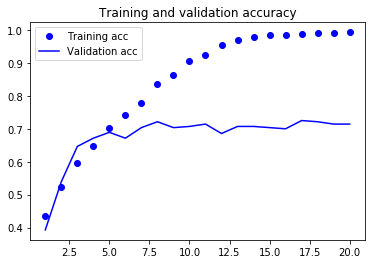

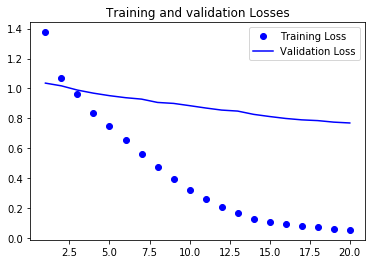

<Figure size 432x288 with 0 Axes>

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training Loss')
plt.plot(epochs, val_loss, 'b', label ='Validation Loss')
plt.title("Training and validation Losses")
plt.legend()
plt.figure()

plt.show()

In [85]:
print(model.metrics_names)
results

['loss', 'acc']


[1.4018997974395753, 0.7020000219345093]

In [100]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

weights[1:20, 0:10]

(10000, 100)


array([[-1.82122029e-02, -2.39151075e-01,  7.34210074e-01,
        -3.90493959e-01,  8.31238553e-02,  4.56140488e-02,
        -4.11497027e-01,  3.16000700e-01, -5.57035387e-01,
         8.30648467e-02],
       [-5.24324477e-01,  3.84427816e-01,  1.01387620e+00,
        -4.35156941e-01,  4.85406518e-01,  2.23095074e-01,
        -8.91147628e-02,  5.04001856e-01,  9.76945907e-02,
        -2.39136651e-01],
       [-2.01886281e-01,  2.25495938e-02,  1.74574718e-01,
        -3.45034897e-02, -9.92642641e-02,  2.00759768e-01,
        -5.37198901e-01,  1.03052035e-01, -1.91663519e-01,
         3.30347806e-01],
       [-2.63797998e-01,  5.67945316e-02, -1.91955604e-02,
        -1.47028804e-01,  6.66998565e-01,  6.85674965e-01,
         3.61096859e-01,  4.76436287e-01, -3.06521654e-01,
         5.21216869e-01],
       [-5.00663877e-01,  7.62043059e-01,  8.82071733e-01,
        -7.91352987e-01, -6.69420481e-01,  6.40109003e-01,
        -4.06469733e-01,  3.82466167e-01,  3.49392503e-01,
        -4.

In [76]:
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)

In [51]:
tsne_embeddings = TSNE(n_components=2).fit_transform(weights)
plot_words(tsne_embeddings, 0, 2, 1)

NameError: name 'word_list' is not defined